Eivind: LSTM, XGB // NN, LR

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf  # module to run ordinary least squares analysis
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score  # Import regression metrics

import warnings
warnings.filterwarnings("ignore")


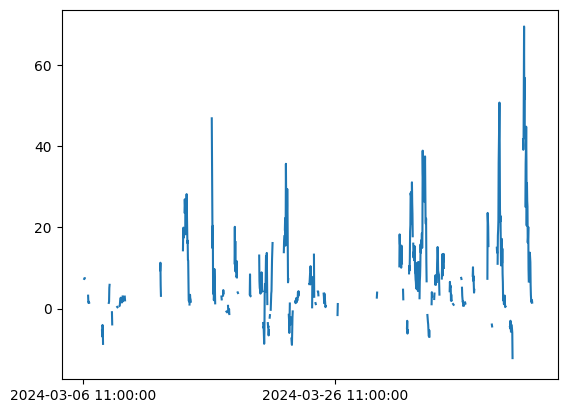

In [47]:
# Real data
# Load and prepare the data
df = pd.read_csv("../data/Tuddal_data.csv", na_values=np.nan)

df["albedo"] = df['R_SW_in'] / df['R_LW_out_corr']

# Define features and target variable
features = ["wind_speed", "max_wind_speed", "R_SW_in", "precip_int_h_D", "albedo",
        "air_temperature", "wind_dir", "specific_humidity",
        "air_pressure", "precip_int_h_D", 
        "FC1DRIFTsum_99_99_1_1_1", "FC2DRIFTsum_99_99_1_1_1"]

df_cont = df.dropna(subset=['LE_qc0']) 
df_cont = df.dropna(subset=features) 

y = df_cont["LE_qc0"] # filtered data
X = df_cont[features] # filtered data
t = df_cont['timestamp'] #filtered data
y2 = df["LE_qc0"] # non-filtered data
t2 = df['timestamp'] # non-filtered data

fig, ax = plt.subplots(1,1)

ax.plot(t2,y2)
ax.set_xticks(ax.get_xticks()[::960])

In [ ]:
# Synthetic data 1 - Not in use
# Generating synthetic data
# Latent heat and the three variables with the highest R-squared when compared with latent heat in linear regression: 
# maximum wind speed (mws), incoming shortwave radiaton (sw_in) and albedo (alb)

# Current state: no covariance implemented between the data 

# Define column statistics based on the original dataset
num_rows = len(df)  # Choose the number of rows for the synthetic dataset
mean_value_le = np.mean(y) # mean of the latent heat data
std_dev_le = np.std(y) # std deviation of the latent heat data

mean_value_mws = np.mean(df_cont['max_wind_speed']) # mean of the max wind speed data
std_dev_mws = np.std(df_cont['max_wind_speed']) # std deviation of the max wind speed data

mean_value_sw_in = np.mean(df_cont['R_SW_in']) # mean of the shortwave in data
std_dev_sw_in = np.std(df_cont['R_SW_in']) # std deviation of the shortwave in data

mean_value_alb = np.mean(df_cont['albedo']) # mean of the albedo data
std_dev_alb = np.std(df_cont['albedo']) # std deviation of the albedo data

# Generate synthetic data
synthetic_le = np.random.normal(mean_value_le, std_dev_le, num_rows)
synthetic_mws = np.random.normal(mean_value_mws, std_dev_mws, num_rows)
synthetic_sw_in = np.random.normal(mean_value_sw_in, std_dev_sw_in, num_rows)
synthetic_alb = np.random.normal(mean_value_alb, std_dev_alb, num_rows)

# Define means and covariance matrix
#mean = [50, 30]
#cov = [[1, 0.8], [0.8, 1]]  # High correlation between two variables
#synthetic_correlated_data = np.random.multivariate_normal(mean, cov, num_rows)

# Separate the columns
#synthetic_column_1, synthetic_column_2 = synthetic_correlated_data[:, 0], synthetic_correlated_data[:, 1]

# Combining columns into a dataframe
synthetic_df = pd.DataFrame({
    'LE_synthetic': synthetic_le,
    'mws_synthetic': synthetic_mws,
    'sw_in_synthetic': synthetic_sw_in,
    'albedo_synthetic': synthetic_alb,
})


                     temperature   humidity  wind_speed  precipitation  \
2023-09-01 00:00:00    13.115481  75.379999    3.454857       1.158215   
2023-09-01 00:30:00    16.189738  55.508375    6.767704       1.459813   
2023-09-01 01:00:00    13.930544  48.158226    4.153968       0.674355   
2023-09-01 01:30:00    11.390507  40.085881    5.324508       0.612367   
2023-09-01 02:00:00    14.643400  55.149971    4.580369       1.295401   

                     solar_radiation  latent_heat  
2023-09-01 00:00:00              0.0    47.615679  
2023-09-01 00:30:00              0.0    40.675353  
2023-09-01 01:00:00              0.0    35.234130  
2023-09-01 01:30:00              0.0    29.150925  
2023-09-01 02:00:00              0.0    39.593172  
        temperature      humidity    wind_speed  precipitation  \
count  17521.000000  17521.000000  17521.000000   17521.000000   
mean      20.354573     60.006456      5.015368       0.033579   
std        7.846096     14.158703      1.4056

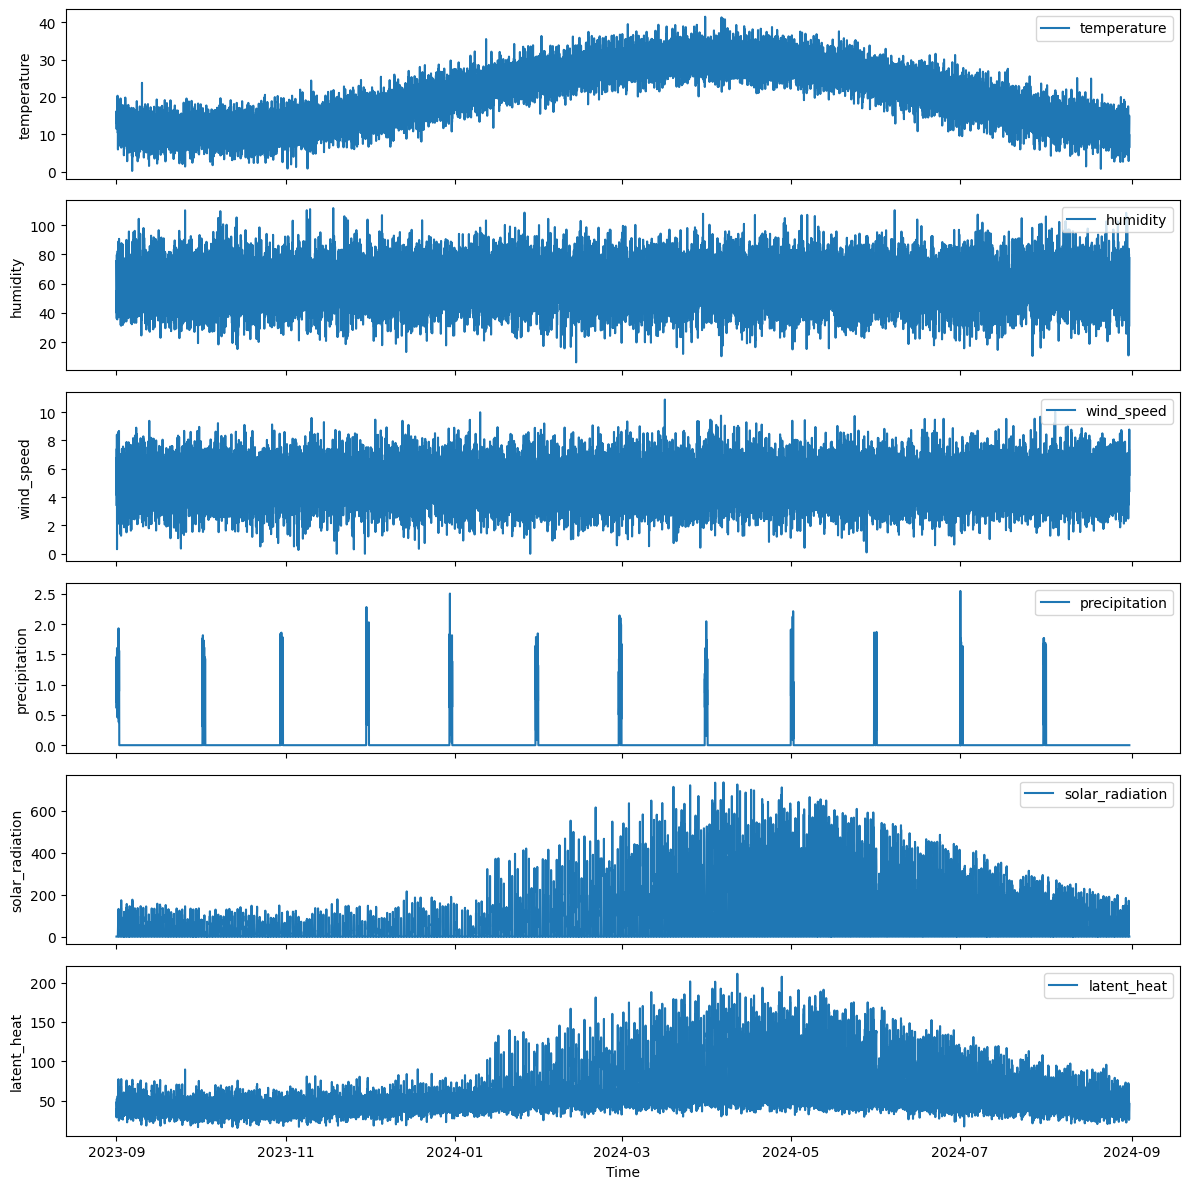

In [96]:
# Synthetic data 2 - In use

# User-defined parameters
params = {
    'latitude': 60,
    'start_date': '2023-09-01',
    'end_date': '2024-08-31',
    'frequency': '30min',
    'feature_means': {
        'temperature': 20,  # Mean temperature in degrees Celsius
        'humidity': 60,  # Mean relative humidity in %
        'wind_speed': 5,  # Mean wind speed in m/s
        'precipitation': 1  # Mean precipitation in mm
    },
    'feature_stds': {
        'temperature': 2,  # Std deviation for temperature
        'humidity': 10,  # Std deviation for humidity
        'wind_speed': 1,  # Std deviation for wind speed
        'precipitation': 0.5  # Std deviation for precipitation
    },
    'average_rainy_days_per_month': [10, 8, 10, 12, 15, 18, 20, 18, 15, 12, 10, 12],  # Average rainy days per month
    'rain_transition_probability': 0.7,  # Probability that a rainy day will be followed by another rainy day
    'seasonal_amplitude': 10,
    'diurnal_amplitude': 2,
    'latent_heat_noise': 0.5,
}

# Define functions
def solar_declination(day_of_year):
    return 23.44 * np.sin(np.radians(360 / 365.24 * (day_of_year - 81)))

def day_length(day_of_year, latitude):
    decl = solar_declination(day_of_year)
    latitude_rad = np.radians(latitude)
    decl_rad = np.radians(decl)
    cos_hour_angle = -np.tan(latitude_rad) * np.tan(decl_rad)
    hour_angle = np.arccos(np.clip(cos_hour_angle, -1, 1))
    day_length_hours = 2 * np.degrees(hour_angle) / 15
    return day_length_hours

def generate_rainy_days(num_days, avg_rainy_days, transition_probability):
    rain_days = np.zeros(num_days)
    actual_rainy_days = min(num_days, avg_rainy_days)
    initial_rain_days = np.random.choice(num_days, actual_rainy_days, replace=False)
    
    for i in initial_rain_days:
        rain_days[i] = 1
        j = i + 1
        while j < num_days and np.random.rand() < transition_probability:
            rain_days[j] = 1
            j += 1

    return rain_days

# Define time period and frequency
time_period = pd.date_range(start=params['start_date'], end=params['end_date'], freq=params['frequency'])
num_samples = len(time_period)
num_days = len(pd.date_range(start=params['start_date'], end=params['end_date'], freq='D'))

# Generate monthly rainy days
rainy_days = np.zeros(num_days)
for month in range(1, 13):
    days_in_month = len(pd.date_range(start=f'2023-{month:02d}-01', end=f'2023-{month:02d}-01', freq='D') + pd.offsets.MonthEnd())
    monthly_rainy_days = generate_rainy_days(days_in_month, params['average_rainy_days_per_month'][month-1], params['rain_transition_probability'])
    start_day = pd.date_range(start=f'2023-{month:02d}-01', end=f'2023-12-31', freq='D').dayofyear[0] - 1
    rainy_days[start_day:start_day+days_in_month] = monthly_rainy_days

rainy_hours = np.repeat(rainy_days, 48)[:num_samples]  # 48 periods per day for half-hourly data

# Generate features based on user-defined means, stds, and additional noise
features = {}
for feature in params['feature_means']:
    base = np.random.normal(loc=params['feature_means'][feature], scale=params['feature_stds'][feature], size=num_samples)
    seasonal_pattern = params['seasonal_amplitude'] * np.sin(2 * np.pi * time_period.dayofyear / 365)
    diurnal_pattern = params['diurnal_amplitude'] * np.sin(2 * np.pi * time_period.hour / 24)

    if feature == 'temperature':
        features[feature] = base + seasonal_pattern + diurnal_pattern
    else:
        features[feature] = base

# Solar radiation and cloudiness factor
latitude = params['latitude']
solar_radiation = np.zeros(num_samples)
cloudiness_factor = np.random.uniform(low=0, high=1, size=num_samples)  # Random cloudiness factor

for i in range(num_samples):
    day_of_year = time_period[i].dayofyear
    hour_of_day = time_period[i].hour + time_period[i].minute / 60.0
    day_length_hours = day_length(day_of_year, latitude)
    max_radiation = 450 + 300 * np.sin(2 * np.pi * (day_of_year / 365))  # Adjust according to seasonality
    
    if hour_of_day < (24 - day_length_hours) / 2 or hour_of_day > 24 - (24 - day_length_hours) / 2:
        radiation = 0  # No radiation outside of daylight hours
    else:
        hour_angle = (hour_of_day - 12) * 2 * np.pi / 24  # Convert time to hour angle in radians
        effective_cloudiness = 1 if rainy_hours[i] == 1 else cloudiness_factor[i]
        reduction_factor = 0.7 if effective_cloudiness == 1 else 1 - effective_cloudiness
        radiation = max_radiation * max(0, np.sin(hour_angle)) * reduction_factor
    
    solar_radiation[i] = radiation

features['solar_radiation'] = solar_radiation
features_df = pd.DataFrame(features, index=time_period)

# Apply cloudiness and rain impact on temperature
temperature_adjustment = np.zeros(num_samples)
for i in range(num_samples):
    hour_of_day = time_period[i].hour
    effective_cloudiness = 1 if rainy_hours[i] == 1 else cloudiness_factor[i]
        
    # Temperature adjustment based on cloudiness and rain
    if effective_cloudiness > 0.5:  # Consider it cloudy if effective_cloudiness is greater than 0.5
        if hour_of_day >= 6 and hour_of_day <= 18:  # Cloudy during daytime
            if time_period[i].month in [6, 7, 8]:  # Summer months
                temperature_adjustment[i] = -2 * effective_cloudiness
            else:  # Other months
                temperature_adjustment[i] = 1 * effective_cloudiness
        else:  # Cloudy during nighttime
            temperature_adjustment[i] = 1.5 * effective_cloudiness
    
features_df['temperature'] += temperature_adjustment

# Apply rainy day impact on precipitation
precipitation_adjustment = np.zeros(num_samples)
for i in range(num_samples):
    if rainy_hours[i] == 1:
        precipitation_adjustment[i] = np.random.normal(loc=params['feature_means']['precipitation'], scale=params['feature_stds']['precipitation'])

features_df['precipitation'] = precipitation_adjustment

# Add noise term to the other features
for feature in features:
    if feature not in ('precipitation', 'solar_radiation'):
        noise = np.random.normal(0, params['feature_stds'].get(feature, 1), num_samples)
        features_df[feature] += noise

# Clip values to ensure they do not go below zero
features_df['precipitation'] = np.clip(features_df['precipitation'], 0, None)
features_df['humidity'] = np.clip(features_df['humidity'], 0, None)
features_df['wind_speed'] = np.clip(features_df['wind_speed'], 0, None)

# Generate the target variable (latent heat) with additional noise term
noise = np.random.normal(0, 1, num_samples)
latent_heat = 0.8 * features_df['temperature'] + 0.5 * features_df['humidity'] + 0.2 * features_df['solar_radiation'] + params['latent_heat_noise'] * noise
features_df['latent_heat'] = latent_heat

# Validate synthetic data
print(features_df.head())
print(features_df.describe())

# Uncomment if you want to save the synthetic dataset
# features_df.to_csv('synthetic_dataset_with_rainy_days.csv', index=True)
# print('Synthetic dataset created successfully!')

# Plot for visual inspection
num_features = len(features_df.columns)

# Create subplots
fig, axs = plt.subplots(num_features, figsize=(12, 2*num_features), sharex=True)

# Loop through each column and plot
for i, column in enumerate(features_df.columns):
    axs[i].plot(features_df.index, features_df[column], label=column)
    axs[i].set_ylabel(column)
    axs[i].legend(loc='upper right')

# Set the common x-label
plt.xlabel('Time')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


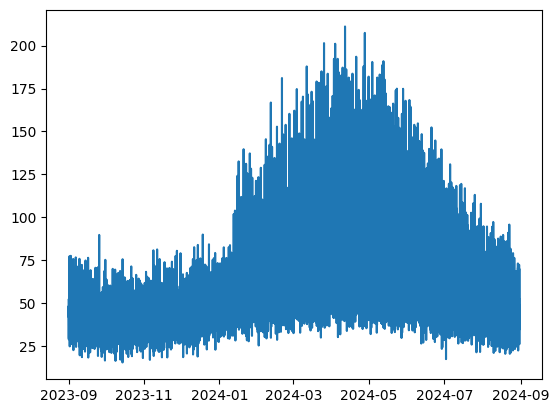

In [98]:
plt.plot(features_df['latent_heat'])

In [97]:
# Generate gaps

df = features_df.copy()

# Simulate time index (one year, 30 min increments)
date_rng = pd.date_range(start='2023-09-01 00:00', end='2024-08-31 00:00', freq='30T')
df.index = date_rng

# Parameters for gap creation
num_gaps = 15
min_gap_size = 5 * 48  # 5 days in 30 min increments
max_gap_size = 15 * 48  # 10 days in 30 min increments
n_rows = len(df)

# Introduce gaps in 'latent_heat'
for _ in range(num_gaps):
    start_idx = np.random.randint(0, n_rows - max_gap_size)
    gap_size = np.random.randint(min_gap_size, max_gap_size)
    df.loc[df.index[start_idx:start_idx + gap_size], 'latent_heat'] = np.nan

print(df['latent_heat'].isna().sum())  # Check the number of NaN values introduced


5687


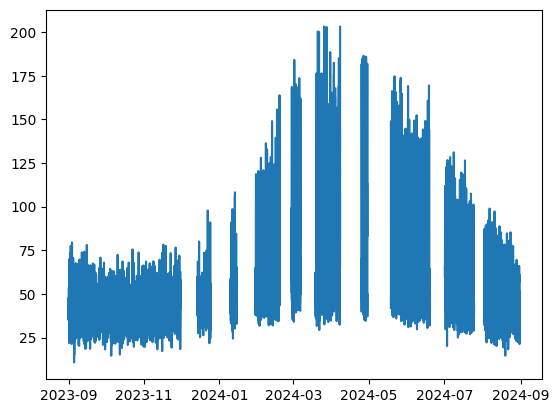

In [67]:
plt.plot(df['latent_heat'])

In [68]:
# Linear regression

from sklearn.linear_model import LinearRegression

# Copy the original dataframe
df_lr = df.copy()

# Prepare training data from rows without NaN values in 'latent_heat'
train_data = df_lr.dropna(subset=['latent_heat'])
X_train = train_data[['temperature', 'humidity', 'wind_speed', 'precipitation', 'solar_radiation']]
y_train = train_data['latent_heat']

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing values
test_data = df_lr[df_lr['latent_heat'].isna()]
X_test = test_data[['temperature', 'humidity', 'wind_speed', 'precipitation', 'solar_radiation']]
y_pred = model.predict(X_test)

# Insert predictions back into the copy dataframe
df_lr.loc[df_lr['latent_heat'].isna(), 'latent_heat'] = y_pred


In [69]:
# XGBoost

from xgboost import XGBRegressor

# Copy the original dataframe
df_xgb = df.copy()

# Prepare training data
train_data = df_xgb.dropna(subset=['latent_heat'])
X_train = train_data[['temperature', 'humidity', 'wind_speed', 'precipitation', 'solar_radiation']]
y_train = train_data['latent_heat']

# Fit the model
model = XGBRegressor()
model.fit(X_train, y_train)

# Predict and update the copy dataframe
X_test = df_xgb.loc[df_xgb['latent_heat'].isna(), ['temperature', 'humidity', 'wind_speed', 'precipitation', 'solar_radiation']]
y_pred = model.predict(X_test)
df_xgb.loc[df_xgb['latent_heat'].isna(), 'latent_heat'] = y_pred


In [70]:
# Neural networks

from sklearn.neural_network import MLPRegressor

# Copy the original dataframe
df_nn = df.copy()

# Prepare training data
train_data = df_nn.dropna(subset=['latent_heat'])
X_train = train_data[['temperature', 'humidity', 'wind_speed', 'precipitation', 'solar_radiation']]
y_train = train_data['latent_heat']

# Fit the neural network model
model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500)
model.fit(X_train, y_train)

# Predict and update the copy dataframe
X_test = df_nn.loc[df_nn['latent_heat'].isna(), ['temperature', 'humidity', 'wind_speed', 'precipitation', 'solar_radiation']]
y_pred = model.predict(X_test)
df_nn.loc[df_nn['latent_heat'].isna(), 'latent_heat'] = y_pred


In [117]:
# LSTM - Long Short-Term Memory

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Copy the original dataframe
df_lstm = df.copy()

# Step 1: Data Preprocessing
# Assuming df_lstm is the dataframe with the preprocessed data
# We are interested in predicting the 'latent_heat' column based on others

# Select relevant features and target
features = df_lstm[['temperature', 'humidity', 'wind_speed', 'precipitation', 'solar_radiation']].values
target = df_lstm['latent_heat'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target.reshape(-1, 1))

# Convert to PyTorch tensors
features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
target_tensor = torch.tensor(target_scaled, dtype=torch.float32)

# Step 2: Create Train and Test datasets
X_train, X_test, y_train, y_test = train_test_split(features_tensor, target_tensor, test_size=0.2, shuffle=False)

# Create DataLoader for batch processing
batch_size = 64
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Step 3: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Take the output of the last time step
        return out

# Define the model, loss function, and optimizer
input_size = features_scaled.shape[1]  # Number of features
hidden_size = 64  # LSTM hidden layer size
output_size = 1  # Predicting a single value (latent_heat)

model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 4: Train the Model
epochs = 20
for epoch in range(epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.unsqueeze(1)  # Add batch size dimension
        labels = labels.unsqueeze(1)
        
        optimizer.zero_grad()  # Zero the gradients
        output = model(inputs)  # Get the model's predictions
        loss = criterion(output, labels)  # Calculate the loss
        loss.backward()  # Backpropagate
        optimizer.step()  # Update weights
    
    if epoch % 5 == 0:  # Print loss every 5 epochs
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# Step 5: Make Predictions on the Test Data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = []
    actual = []
    for inputs, labels in test_loader:
        inputs = inputs.unsqueeze(1)
        labels = labels.unsqueeze(1)
        pred = model(inputs)
        predictions.append(pred)
        actual.append(labels)
    
    predictions = torch.cat(predictions, dim=0)
    actual = torch.cat(actual, dim=0)

# Step 6: Inverse Transform Predictions
predictions = predictions.numpy()
actual = actual.numpy()

# Since we normalized the data, we need to inverse the scaling to get the original scale
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(actual)

# Step 7: Plot the Results
plt.figure(figsize=(10, 6))
plt.plot(df_lstm.index[-len(actual):], actual, label='Actual', color='blue', alpha=0.6)
plt.plot(df_lstm.index[-len(predictions):], predictions, label='Predicted', color='red', linestyle='--', alpha=0.6)
plt.title('Actual vs Predicted Latent Heat')
plt.xlabel('Time')
plt.ylabel('Latent Heat')
plt.legend()
plt.show()


Epoch 1/20, Loss: nan
Epoch 6/20, Loss: nan
Epoch 11/20, Loss: nan
Epoch 16/20, Loss: nan


ValueError: Found array with dim 3. None expected <= 2.

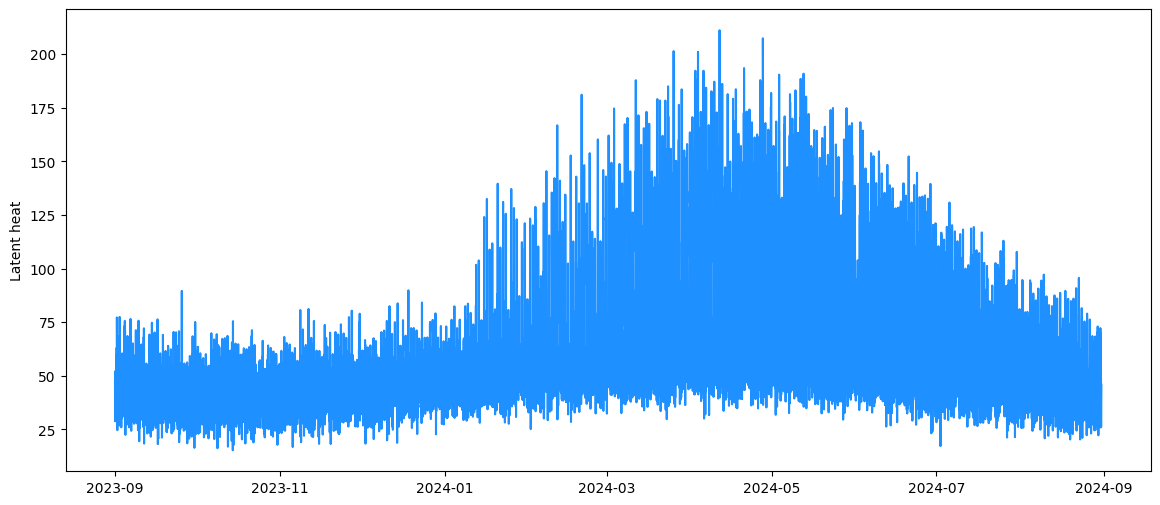

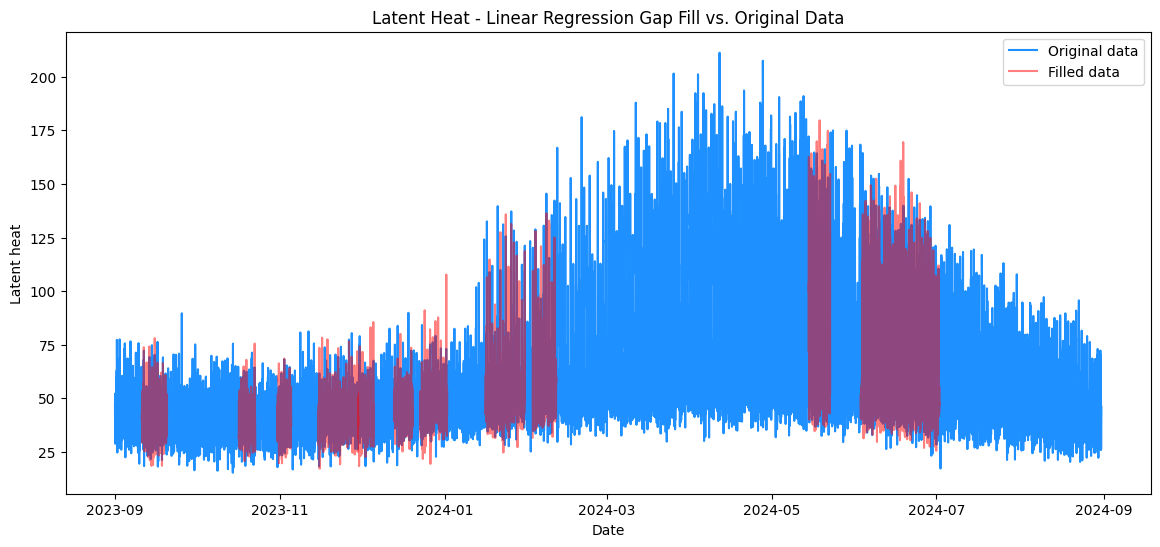

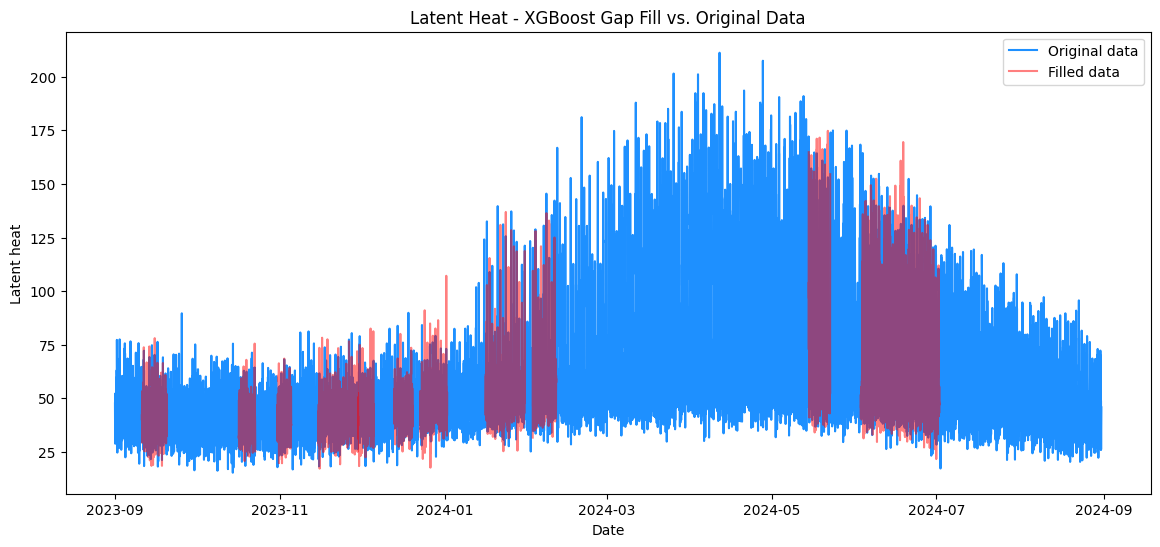

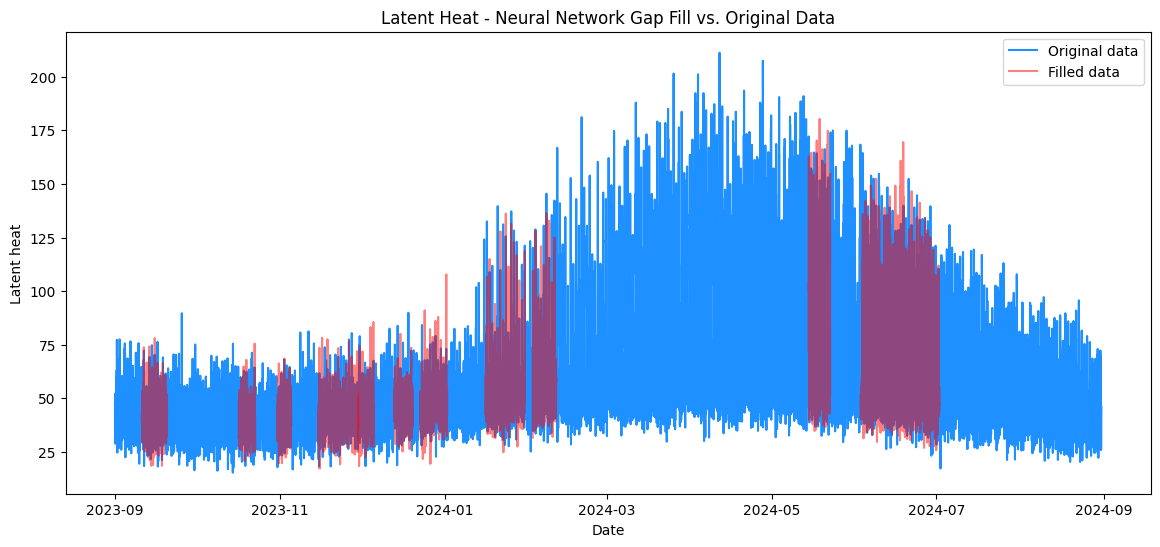

In [116]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot original data, gap-filled data, and actual data without gaps for comparison
def plot_filled_data_with_comparison(dataframe, features_df, title):
    plt.figure(figsize=(14, 6))

    # Plot the actual, complete data from features_df in a transparent line
    plt.plot(features_df.index, features_df['latent_heat'], color='dodgerblue', alpha=1, label='Original data')

    # Plot the original (non-gap-filled) data from df
    original_data_mask = df['latent_heat'].notna()
    #plt.plot(df.index[original_data_mask], df['latent_heat'][original_data_mask], color='blue', alpha=0.7, label='Original Data')

    # Identify and plot each gap-filled segment from df in a transparent line
    filled_data_mask = ~original_data_mask  # True where data was filled
    gap_boundaries = np.where(np.diff(filled_data_mask.astype(int)) != 0)[0]
    gap_segments = [(gap_boundaries[i] + 1, gap_boundaries[i + 1] + 1) for i in range(0, len(gap_boundaries) - 1, 2)]

    # Plot each gap-filled segment individually
    for start, end in gap_segments:
        plt.plot(dataframe.index[start:end], dataframe['latent_heat'].iloc[start:end], color='red', linestyle='-', alpha=0.5, label='Filled data')

    # Avoid duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # Plot formatting
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Latent heat')
    plt.show()

# Plotting original data
plt.figure(figsize=(14, 6))
plt.plot(features_df.index, features_df['latent_heat'],label='Original data',color='dodgerblue')
plt.ylabel('Latent heat')

# Plotting each method's result for comparison
plot_filled_data_with_comparison(df_lr, features_df, "Latent Heat - Linear Regression Gap Fill vs. Original Data")
plot_filled_data_with_comparison(df_xgb, features_df, "Latent Heat - XGBoost Gap Fill vs. Original Data")
plot_filled_data_with_comparison(df_nn, features_df, "Latent Heat - Neural Network Gap Fill vs. Original Data")
#plot_filled_data_with_comparison(df_lstm, features_df, "Latent Heat - LSTM Gap Fill vs. Original Data")


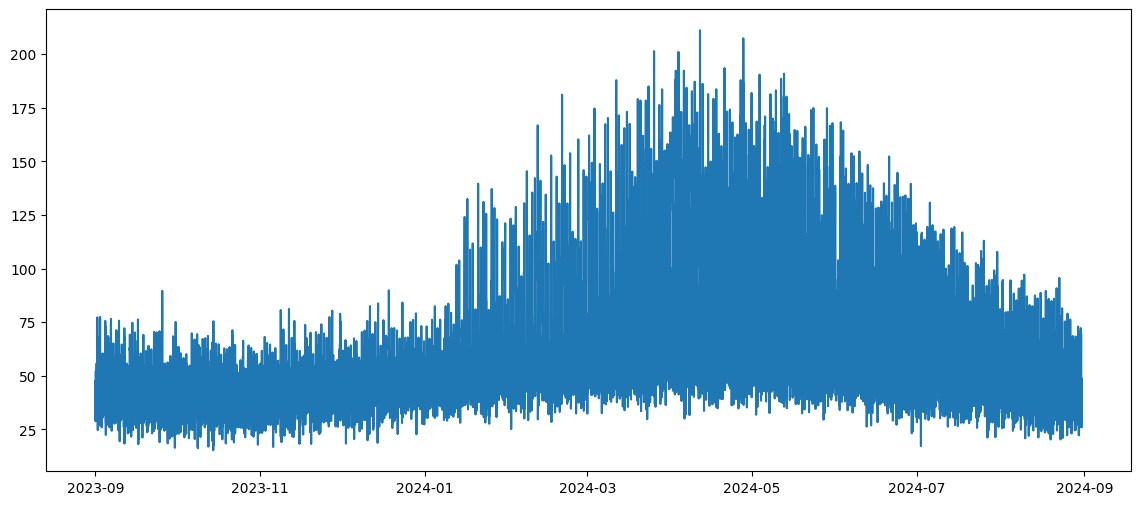

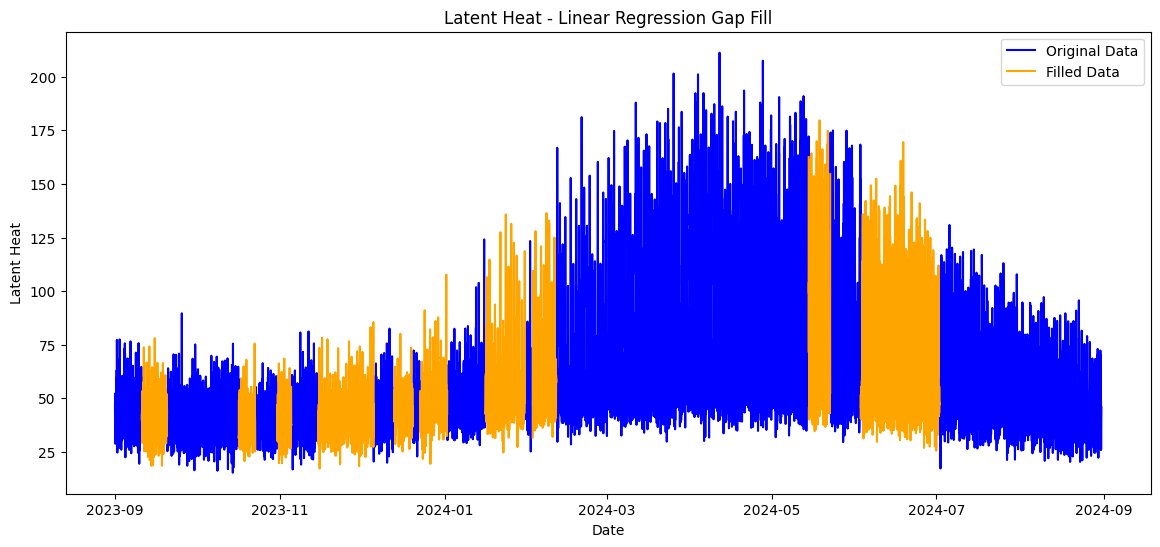

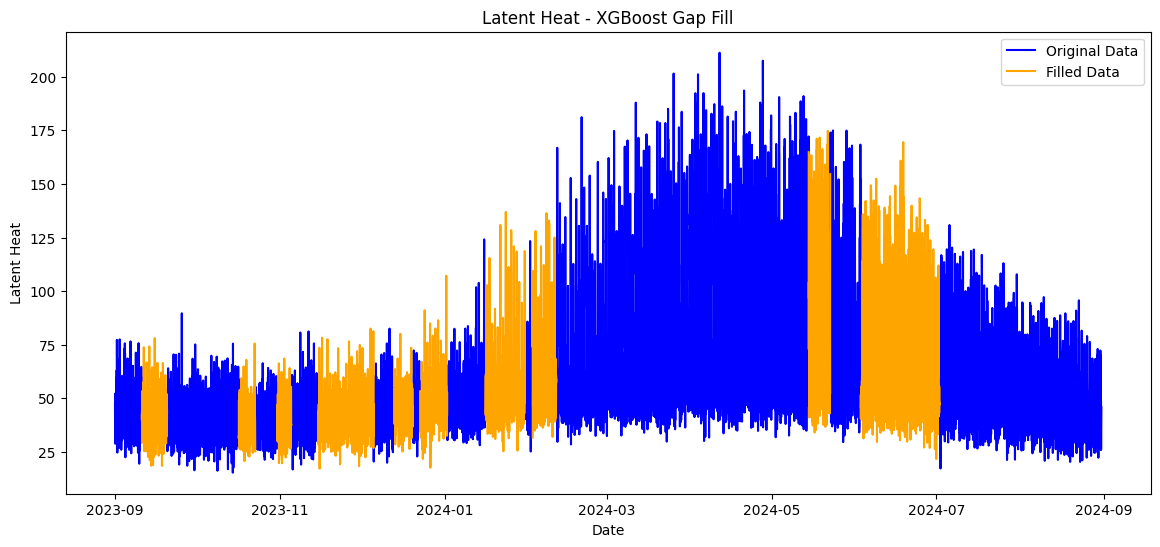

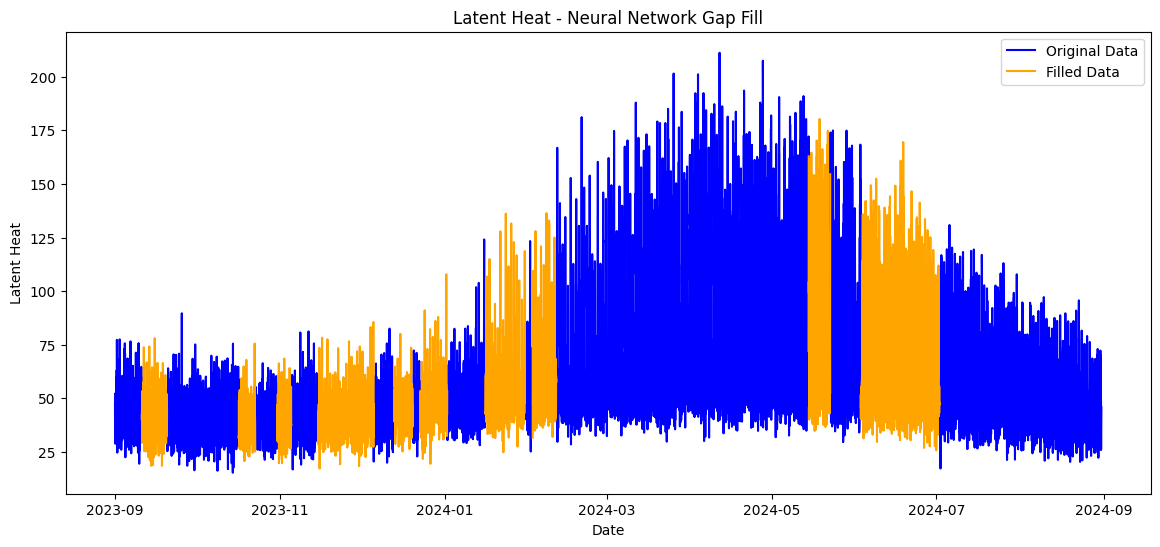

NameError: name 'df_lstm' is not defined

In [ ]:
# Function to plot original and filled values with lines for each gap segment
def plot_filled_data(dataframe, title):
    plt.figure(figsize=(14, 6))

    # Plot original data
    original_data_mask = df['latent_heat'].notna()
    plt.plot(df.index[original_data_mask], df['latent_heat'][original_data_mask], color='blue', label='Original Data')

    # Identify gaps in the latent_heat data
    filled_data_mask = ~original_data_mask  # True where data was filled

    # Detect start and end points of each gap segment
    gap_boundaries = np.where(np.diff(filled_data_mask.astype(int)) != 0)[0]
    gap_segments = [(gap_boundaries[i] + 1, gap_boundaries[i + 1] + 1) for i in range(0, len(gap_boundaries) - 1, 2)]

    # Plot each gap-filled segment as a line
    for start, end in gap_segments:
        plt.plot(dataframe.index[start:end], dataframe['latent_heat'].iloc[start:end], color='orange', linestyle='-', label='Filled Data')

    # Avoid duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # Plot formatting
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Latent Heat')
    plt.show()

# Plotting original data
plt.figure(figsize=(14, 6))
plt.plot(features_df.index, features_df['latent_heat'],label='Original data')

# Plotting each method's result
plot_filled_data(df_lr, "Latent Heat - Linear Regression Gap Fill")
plot_filled_data(df_xgb, "Latent Heat - XGBoost Gap Fill")
plot_filled_data(df_nn, "Latent Heat - Neural Network Gap Fill")
#plot_filled_data(df_lstm, "Latent Heat - LSTM Gap Fill")



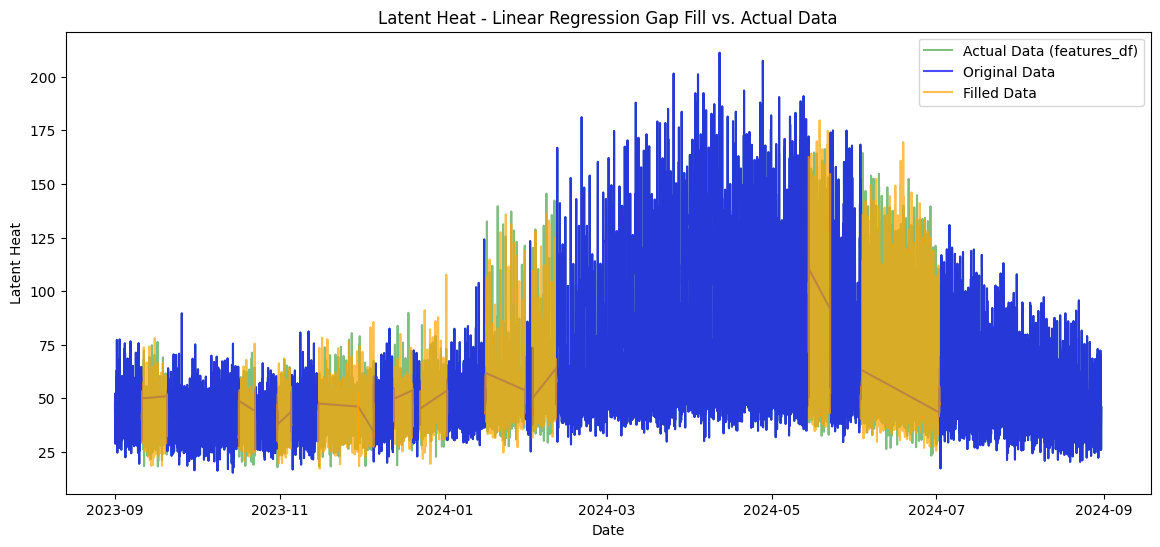

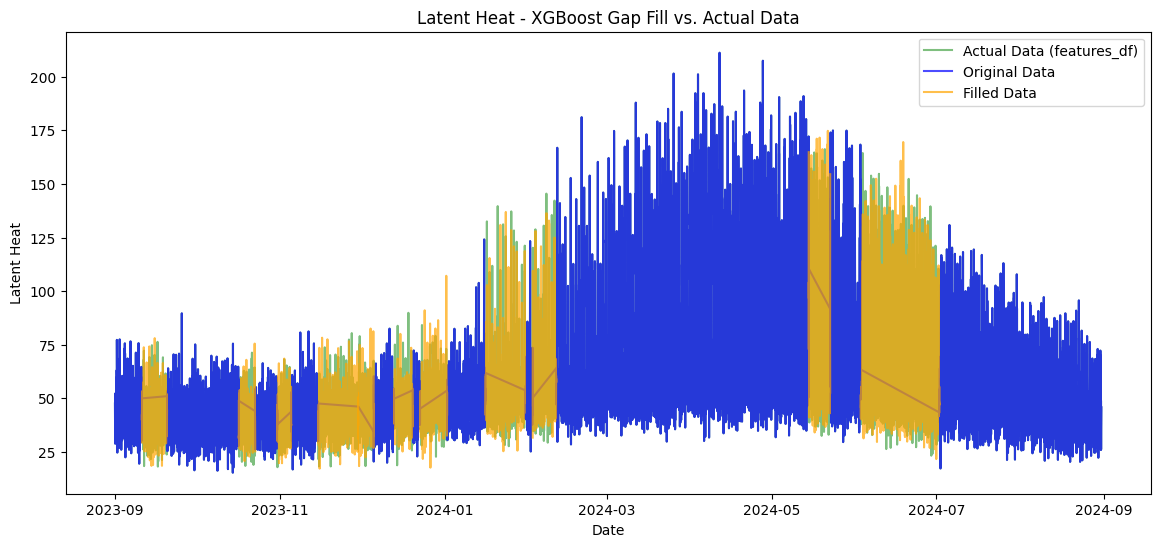

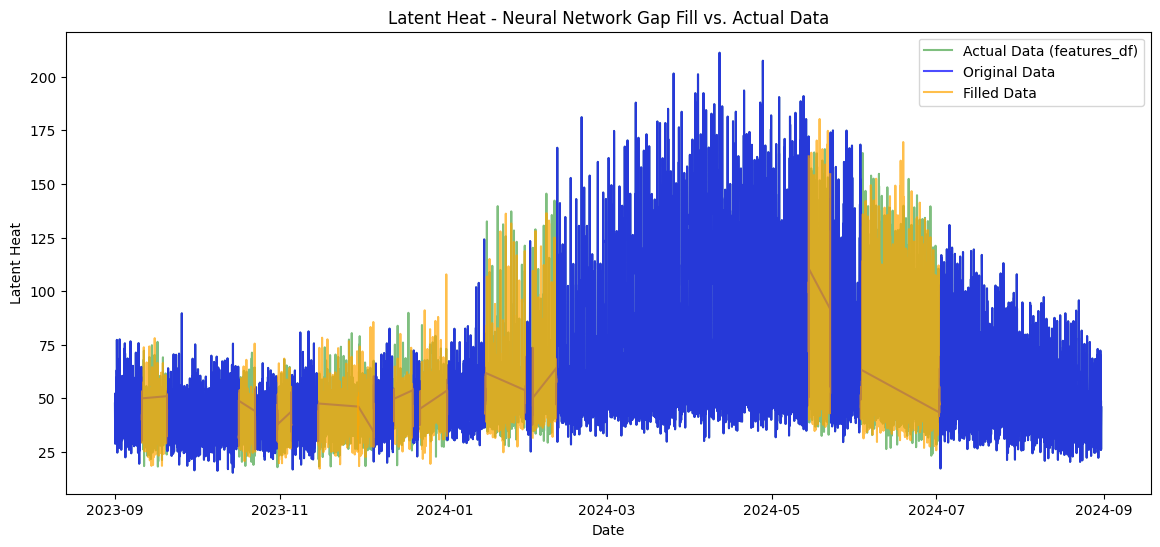

NameError: name 'df_lstm' is not defined

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot original data, gap-filled data, and actual data without gaps for comparison
def plot_filled_data_with_comparison(dataframe, features_df, title):
    plt.figure(figsize=(14, 6))

    # Plot the original, complete data from features_df in a transparent line
    plt.plot(features_df.index, features_df['latent_heat'], color='green', alpha=0.5, label='Actual Data (features_df)')

    # Plot the original (non-gap-filled) data from df
    original_data_mask = df['latent_heat'].notna()
    plt.plot(df.index[original_data_mask], df['latent_heat'][original_data_mask], color='blue', alpha=0.7, label='Original Data')

    # Identify and plot each gap-filled segment from df in a transparent line
    filled_data_mask = ~original_data_mask  # True where data was filled
    gap_boundaries = np.where(np.diff(filled_data_mask.astype(int)) != 0)[0]
    gap_segments = [(gap_boundaries[i] + 1, gap_boundaries[i + 1] + 1) for i in range(0, len(gap_boundaries) - 1, 2)]
    
    for start, end in gap_segments:
        plt.plot(dataframe.index[start:end], dataframe['latent_heat'].iloc[start:end], color='orange', linestyle='-', alpha=0.7, label='Filled Data')

    # Avoid duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # Plot formatting
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Latent Heat')
    plt.show()

# Plotting each method's result for comparison
plot_filled_data_with_comparison(df_lr, features_df, "Latent Heat - Linear Regression Gap Fill vs. Actual Data")
plot_filled_data_with_comparison(df_xgb, features_df, "Latent Heat - XGBoost Gap Fill vs. Actual Data")
plot_filled_data_with_comparison(df_nn, features_df, "Latent Heat - Neural Network Gap Fill vs. Actual Data")
plot_filled_data_with_comparison(df_lstm, features_df, "Latent Heat - LSTM Gap Fill vs. Actual Data")


Text(0, 0.5, 'Latent heat')

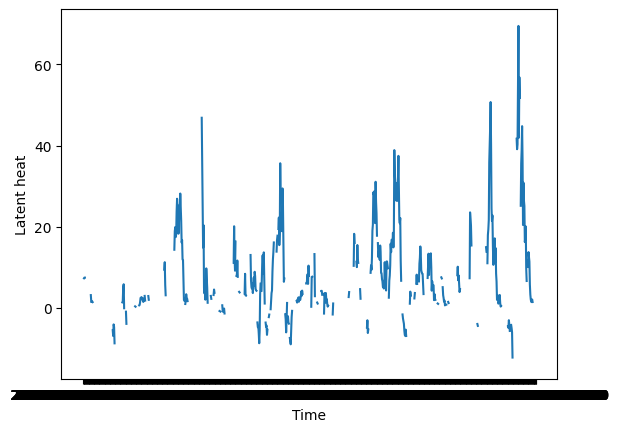

In [66]:
# Plots the non-filtered data to get an overview
plt.plot(t,y)
plt.xlabel('Time')
plt.ylabel('Latent heat')

In [69]:
decomposition=seasonal_decompose(x=df['LE_qc0'], model='additive', period=1).plot() # period = 1 because it's annual data

ValueError: This function does not handle missing values

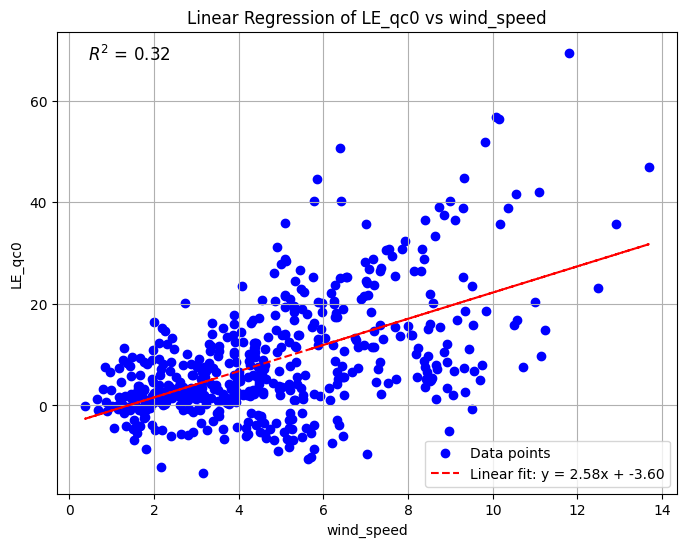

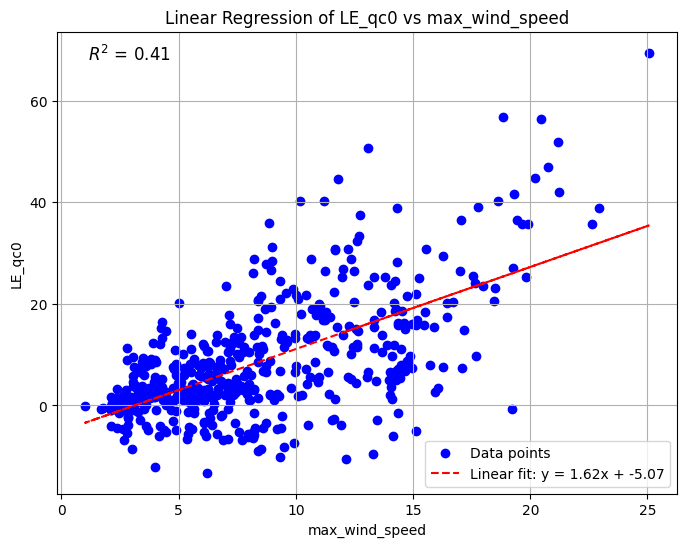

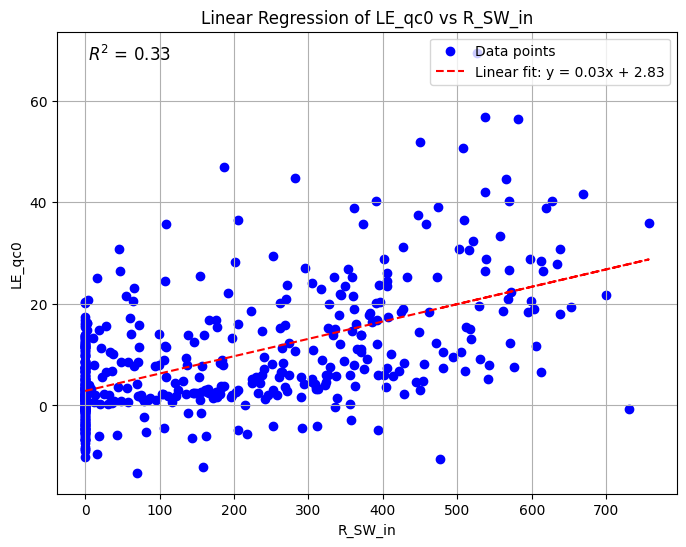

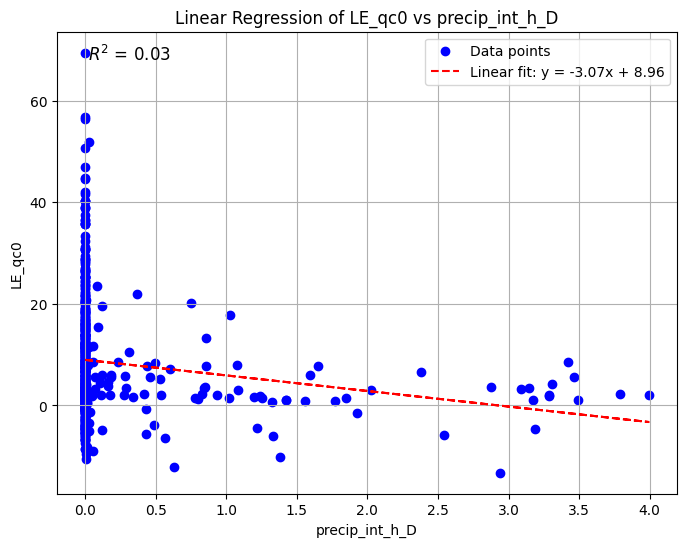

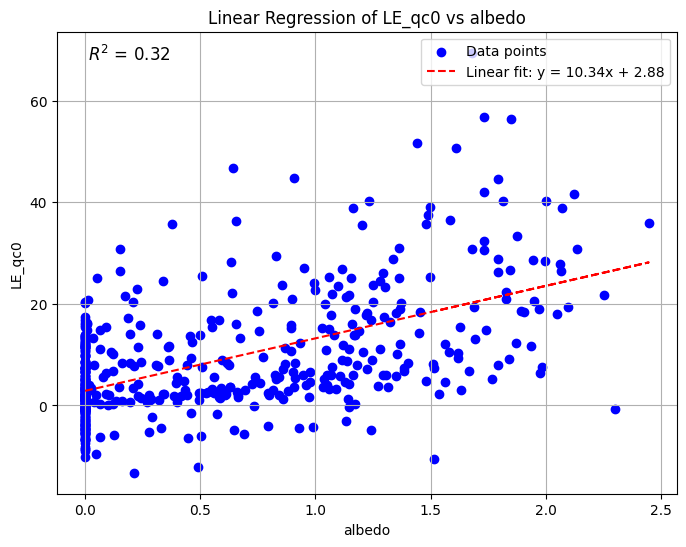

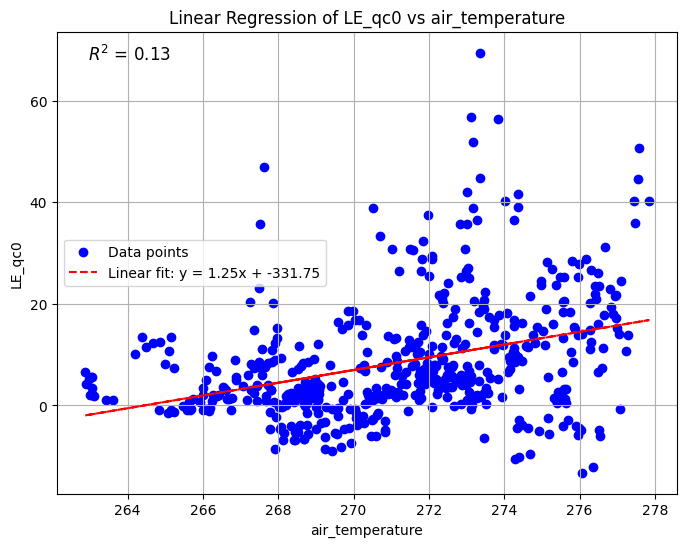

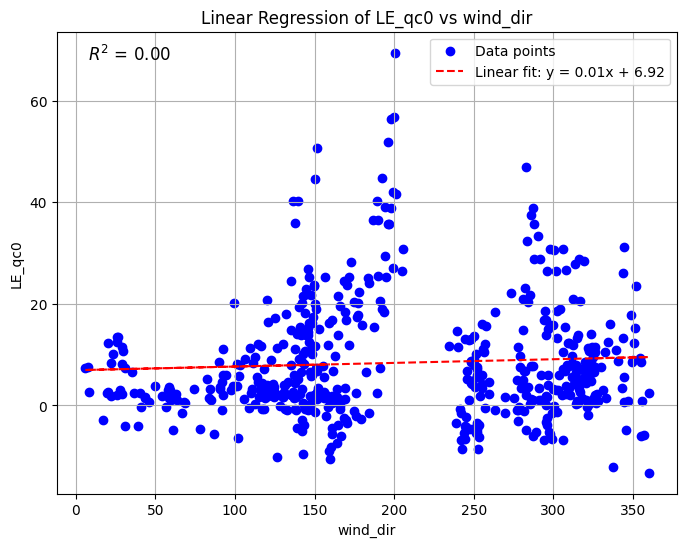

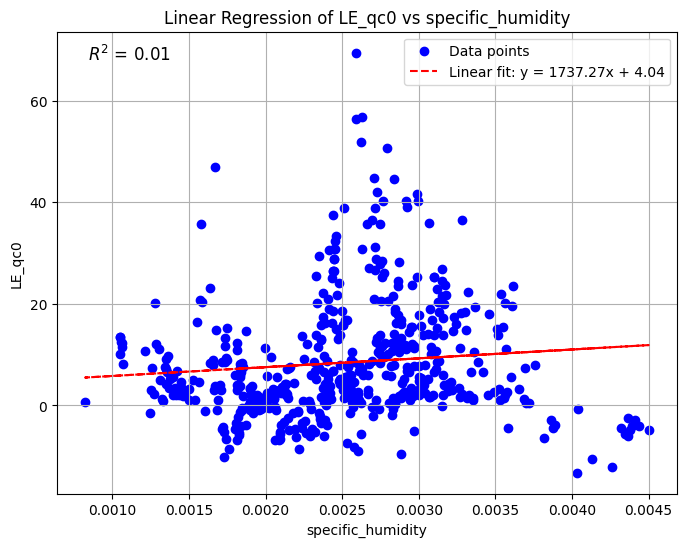

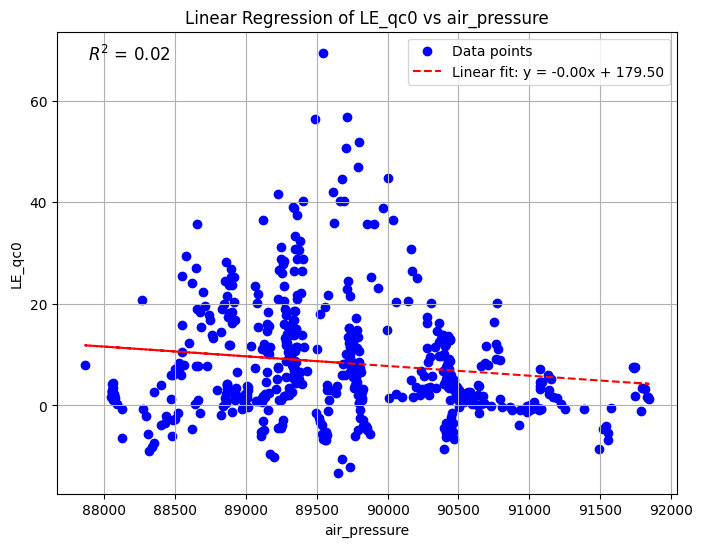

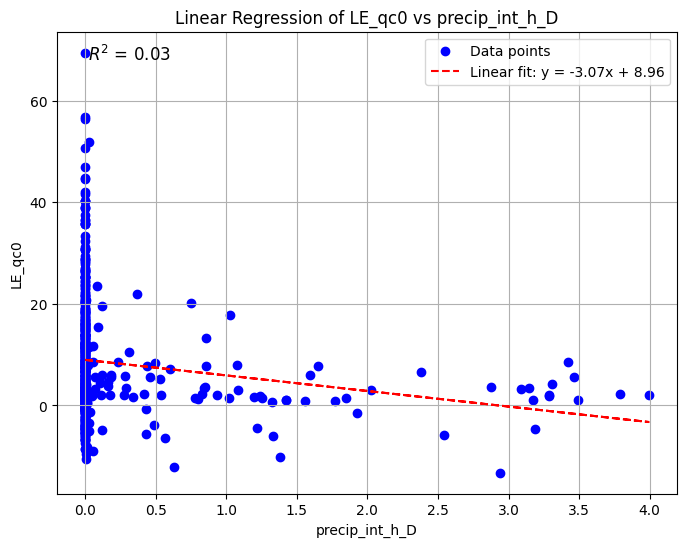

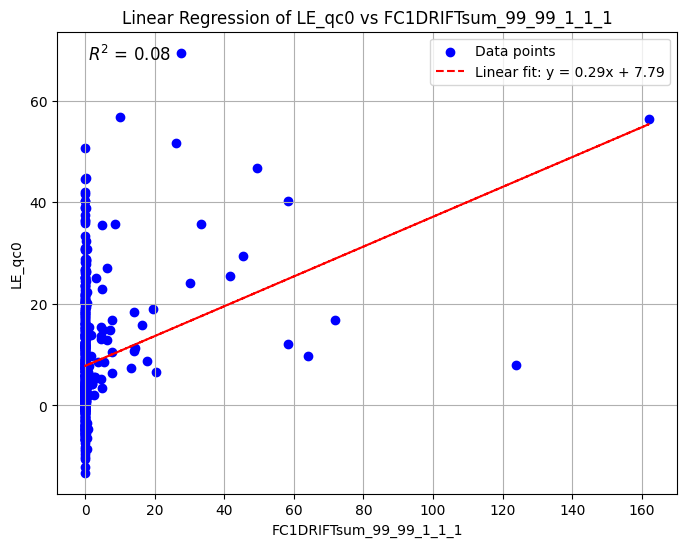

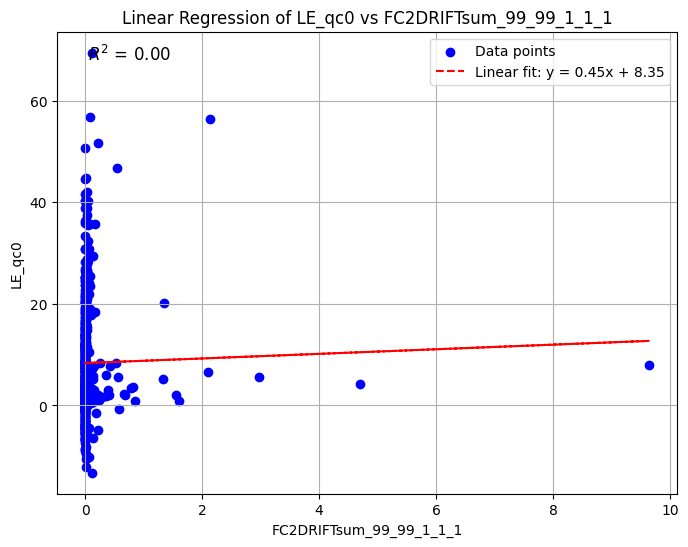

In [35]:
# Initialize empty lists for intercept, slope, and R-squared values
intercept = []
slope = []
r_squared = []

# Loop over the indices and elements of 'features' to ensure integer index access
for i, param in enumerate(features):
    # Perform linear regression on the specified parameter
    linfit = smf.ols(formula=f'LE_qc0 ~ {param}', data=df_cont[[param, 'LE_qc0']]).fit()
    intercept_input, slope_input = linfit.params
    r2_value = linfit.rsquared
    
    # Append the intercept, slope, and R-squared values to their respective lists
    intercept.append(intercept_input)
    slope.append(slope_input)
    r_squared.append(r2_value)
    
    # Plot the data and regression line
    plt.figure(figsize=(8, 6))
    plt.scatter(df_cont[param], df_cont['LE_qc0'], color='blue', label='Data points')
    
    # Create the regression line using the slope and intercept
    x_vals = np.array(df_cont[param])
    y_vals = intercept_input + slope_input * x_vals
    plt.plot(x_vals, y_vals, color='red', label=f'Linear fit: y = {slope_input:.2f}x + {intercept_input:.2f}',ls='--')
    
    # Add the R-squared value to the plot
    plt.text(0.05, 0.95, f'$R^2$ = {r2_value:.2f}', ha='left', va='center', transform=plt.gca().transAxes, fontsize=12, color='black')
    
    # Set plot labels and title
    plt.xlabel(param)
    plt.ylabel('LE_qc0')
    plt.title(f'Linear Regression of LE_qc0 vs {param}')
    plt.legend()
    plt.grid(True)
    plt.show()



Text(0.5, 0, 'Y')

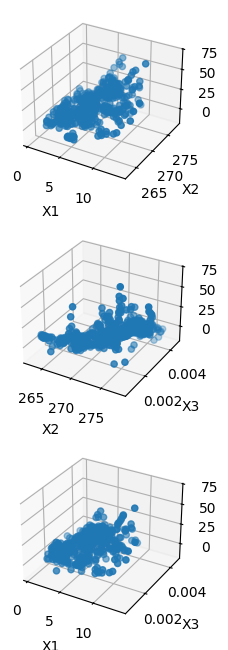

In [18]:
# Plotting the data in 3D space

x1=df['wind_speed']
x2=df['air_temperature']
x3=df['specific_humidity']

fig = plt.figure(figsize=(4,8))
ax1 = fig.add_subplot(311, projection='3d')
ax2 = fig.add_subplot(312, projection='3d')
ax3 = fig.add_subplot(313, projection='3d')

ax1.scatter(x1, x2, y)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel("Y")
#ax1.set_box_aspect(aspect=None, zoom=0.8)

ax2.scatter(x2, x3, y)
ax2.set_xlabel('X2')
ax2.set_ylabel('X3')
ax2.set_zlabel("Y")
#ax2.set_box_aspect(aspect=None, zoom=0.8)

ax3.scatter(x1, x3, y)
ax3.set_xlabel('X1')
ax3.set_ylabel('X3')
ax3.set_zlabel("Y")
#ax3.set_box_aspect(aspect=None, zoom=0.8)

In [10]:
# Exploring synthetic dataset

synthetic_df.describe()

,LE_synthetic,mws_synthetic,sw_in_synthetic,albedo_synthetic
count,1729.000000,1729.000000,1729.000000,1729.000000
mean,8.408734,6.989181,117.861220,0.401013
std,11.110996,5.092429,182.201856,0.606194
min,-23.592228,-9.003693,-528.312812,-1.756219
25%,1.001598,3.433094,-2.303098,-0.011460
50%,8.209048,6.879408,122.981861,0.381011
75%,15.779921,10.523159,239.409286,0.821688
max,48.320944,21.337789,705.909843,2.196292


In [ ]:
# xgboost

